In [1]:
!pip install keras-tuner -q
!pip install visualkeras

import visualkeras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img , img_to_array
from tensorflow.keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten , BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import drive

drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 35.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
!nvidia-smi

Tue Mar 28 15:08:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
num_classes = 10
input_shape = (32, 32, 3)
weight_decay = 0.0001
batch_size = 32
epoch = 100

In [4]:
# Load cifar10 dataset
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [5]:
print('Train Images', x_train.shape[0])
print('Test Images', x_test.shape[0])

Train Images 50000
Test Images 10000


In [6]:
def normalize(x):
    return x.astype('float32') / 255.0

datagen = ImageDataGenerator(rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True)

In [7]:
x_train = normalize(x_train)
x_test = normalize(x_test)

y_train = to_categorical(y_train , num_classes)
y_test = to_categorical(y_test , num_classes)

datagen.fit(x_train)

In [8]:
def save_results(history):
  # Plot training and validation accuracy.
  plt.figure(figsize=(10,6))
  sb.set_style("whitegrid")
  plt.plot(history.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(history.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='lower right')
  plt.savefig('/content/gdrive/My Drive/Image Classification/with_tuning/train_val_acc.png')
  plt.show()

  # Plot training and validation loss.
  plt.figure(figsize=(10,6))
  sb.set_style("whitegrid")
  plt.plot(history.history['loss'],color="Purple",marker='o')
  plt.plot(history.history['val_loss'],color='Orange',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.savefig('/content/gdrive/My Drive/Image Classification/with_tuning/train_val_loss.png')
  plt.show()

In [9]:
class CustomModel(HyperModel):
    def __init__(self, input_shape, num_classes, weight_decay):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.weight_decay = weight_decay

    def create_model(self, hp):
      custom_model = Sequential([Conv2D(hp.Int('conv_1', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(self.weight_decay), input_shape=self.input_shape),
                          BatchNormalization(),
                          Conv2D(hp.Int('conv_1', min_value=64, max_value=128, step=64), (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(self.weight_decay), padding='same'),
                          BatchNormalization(),
                          MaxPooling2D((2, 2)),
                          Dropout(0.2),

                          Conv2D(hp.Int('conv_2', min_value=128, max_value=256, step=128), (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(self.weight_decay), padding='same'),
                          BatchNormalization(),
                          Conv2D(hp.Int('conv_2', min_value=128, max_value=256, step=128), (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(self.weight_decay), padding='same'),
                          BatchNormalization(),
                          MaxPooling2D((2, 2)),
                          Dropout(0.3),

                          Conv2D(hp.Int('conv_3', min_value=256, max_value=512, step=256), (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(self.weight_decay), padding='same'),
                          BatchNormalization(),
                          Conv2D(hp.Int('conv_3', min_value=256, max_value=512, step=256), (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(self.weight_decay), padding='same'),
                          BatchNormalization(),
                          MaxPooling2D((2, 2)),
                          Dropout(0.4),

                          Flatten(),
                          Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(self.num_classes, activation='softmax')])
      
      model_lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

      custom_model.compile(optimizer=Adam(learning_rate=model_lr), loss='categorical_crossentropy', metrics=['accuracy'])
      

      return custom_model

    def optimize(self, x_train, y_train, x_test, y_test, trials=5):
        tuner = kt.Hyperband(hypermodel=self.create_model, objective='val_accuracy', max_epochs=25, factor=3, seed=42, overwrite=True, directory='/content/gdrive/My Drive/Image Classification/with_tuning/', project_name='ImageClassification')

        tuner.search_space_summary()

        print('performing hyperparameter search...')
        tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                                                                               patience=5)])
        # Get the best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print("Best learning rate: {:.4f}".format(best_hps.get("learning_rate")))
        print("[INFO] optimal number of filters in conv_1 layer: {}".format(best_hps.get("conv_1")))
        print("[INFO] optimal number of filters in conv_2 layer: {}".format(best_hps.get("conv_2")))
        print("[INFO] optimal number of filters in conv_3 layer: {}".format(best_hps.get("conv_3")))
        print("[INFO] optimal number of units in dense layer: {}".format(best_hps.get("dense_units")))

        best_model = tuner.get_best_models(num_models=1)[0]

        # Build the model with the best hyperparameters.
        best_model = tuner.hypermodel.build(best_hps)

        return best_model

      
custom_model = CustomModel(input_shape=input_shape, num_classes=num_classes, weight_decay=weight_decay).create_model(HyperParameters())

best_model = CustomModel(input_shape=input_shape, num_classes=num_classes, weight_decay=weight_decay).optimize(x_train, y_train, x_test, y_test)

Trial 30 Complete [00h 02m 16s]
val_accuracy: 0.835099995136261

Best val_accuracy So Far: 0.8633999824523926
Total elapsed time: 01h 02m 17s
Best learning rate: 0.0010
[INFO] optimal number of filters in conv_1 layer: 64
[INFO] optimal number of filters in conv_2 layer: 256
[INFO] optimal number of filters in conv_3 layer: 256
[INFO] optimal number of units in dense layer: 512


In [10]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', 
                               patience=10,
                               cooldown=1,
                               verbose=1),
             EarlyStopping(monitor='val_loss',
                           patience=15,
                           verbose=1)]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

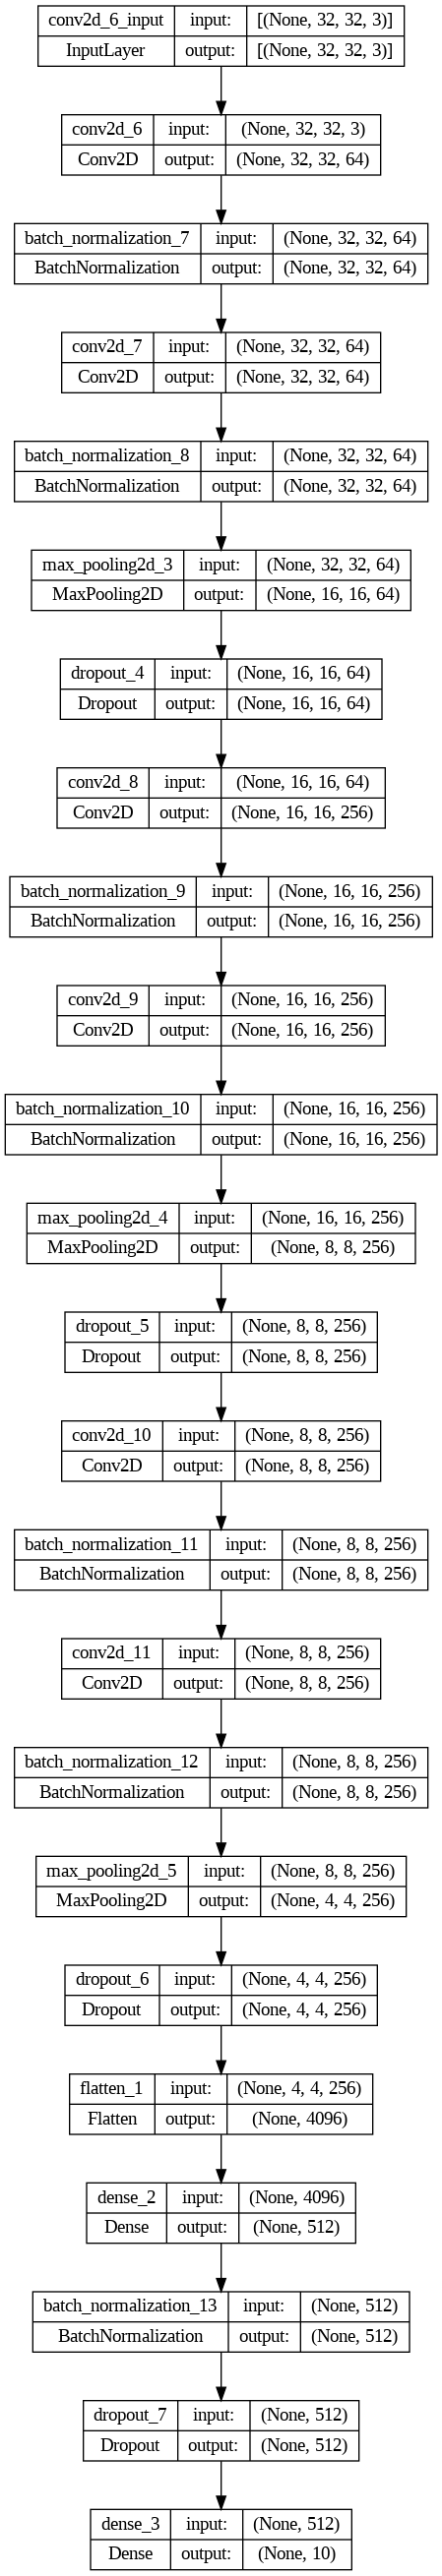

In [11]:
# Plot the best model architecture
best_model.summary()
plot_model(best_model, to_file='/content/gdrive/My Drive/Image Classification/with_tuning/best_model_plot.png', show_shapes=True)

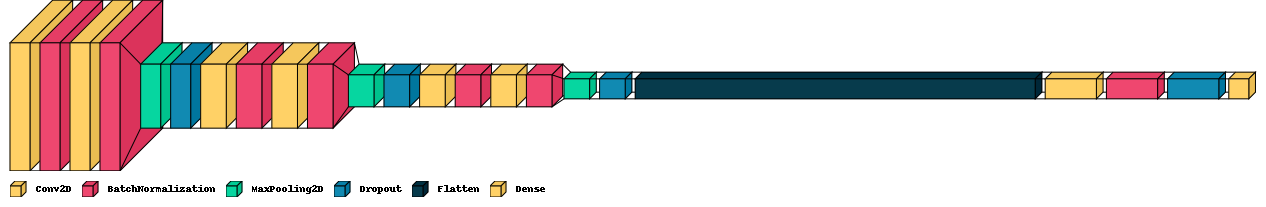

In [12]:
visualkeras.layered_view(best_model, legend=True, to_file='/content/gdrive/My Drive/Image Classification/with_tuning/best_model_architecture.png').show()

In [13]:
print("Training the best model...")
best_model_history = best_model.fit(datagen.flow(x_train , y_train , batch_size = batch_size), epochs = epoch, validation_data = (x_test, y_test) , callbacks=callbacks)

Training the best model...
Epoch 1/100
1563/1563 [==============================] - 34s 19ms/step - loss: 1.7971 - accuracy: 0.4344 - val_loss: 1.4152 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.2305 - accuracy: 0.6144 - val_loss: 1.5752 - val_accuracy: 0.5853 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1145 - accuracy: 0.6763 - val_loss: 1.3792 - val_accuracy: 0.6405 - lr: 0.0010
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0878 - accuracy: 0.7152 - val_loss: 1.1148 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 5/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.0630 - accuracy: 0.7403 - val_loss: 1.1336 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 6/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0656 - accuracy: 0.7556 - val_loss: 1.0809 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 7/100
1

In [14]:
best_model_test_loss, best_model_test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (best_model_test_acc*100))
print("Test Loss: %.2f%%" % (best_model_test_loss*100))

Test Accuracy: 91.39%
Test Loss: 41.75%


In [15]:
val_acc_per_epoch = best_model_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Best epoch: 95


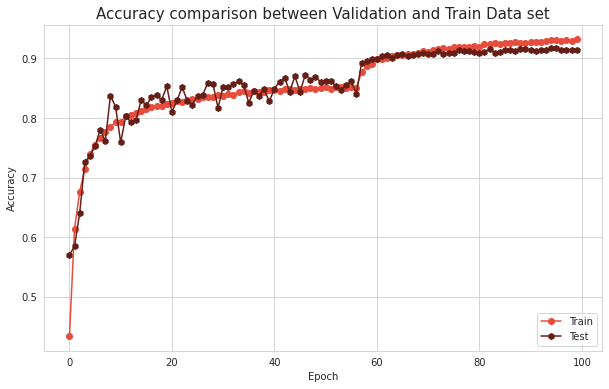

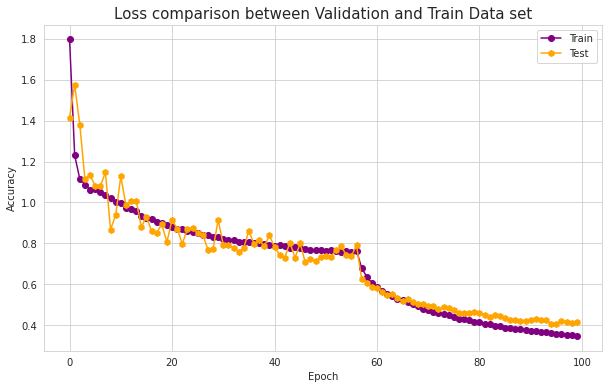

In [16]:
save_results(best_model_history)

In [17]:
# Save best model
best_model.save("/content/gdrive/My Drive/Colab_Models/with_tuning/final_best_model/final_best_model.h5")

In [18]:
from google.colab import runtime
runtime.unassign()